In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
import math
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#Loading Data
data = pd.read_csv("StudentsPerformance.csv")

In [3]:
data.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
#Formatting column names
data = data.rename(columns = {'gender':'Gender', 'race/ethnicity':'Group', 'parental level of education':'PEducation',
                      'lunch':'Lunch', 'test preparation course':'CourseStatus','math score':'MScore',
                      'reading score':'RScore','writing score':'WScore'})

In [5]:
#Checking to see if we have missing data
data.describe()

,MScore,RScore,WScore
count,1000.000,1000.000,1000.000
mean,66.089,69.169,68.054
std,15.163,14.600,15.196
min,0.000,17.000,10.000
25%,57.000,59.000,57.750
50%,66.000,70.000,69.000
75%,77.000,79.000,79.000
max,100.000,100.000,100.000


In [6]:
#Checking Correlations
data.corr()

,MScore,RScore,WScore
MScore,1.000,0.818,0.803
RScore,0.818,1.000,0.955
WScore,0.803,0.955,1.000


In [7]:
#Checking Null values
data.isnull().sum()

Gender          0
Group           0
PEducation      0
Lunch           0
CourseStatus    0
MScore          0
RScore          0
WScore          0
dtype: int64

## KNN Regression Model

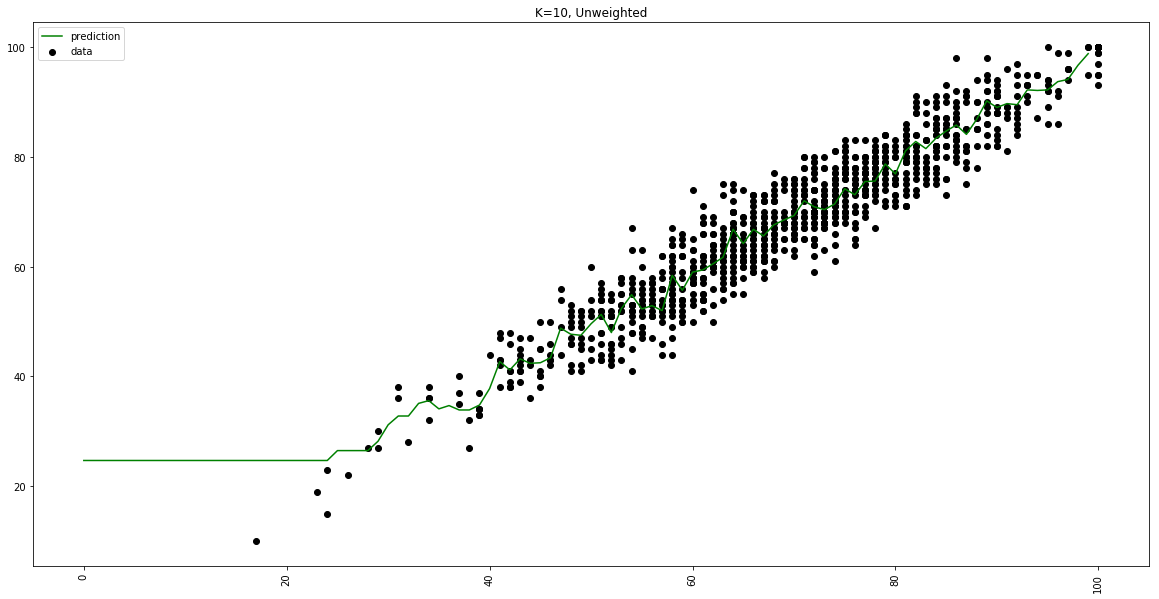

In [8]:

from sklearn import neighbors
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(data.RScore)
Y = data.WScore
knn.fit(X, Y)

# Set up prediction line
T = np.arange(0, 100, 1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xticks(rotation=90)
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

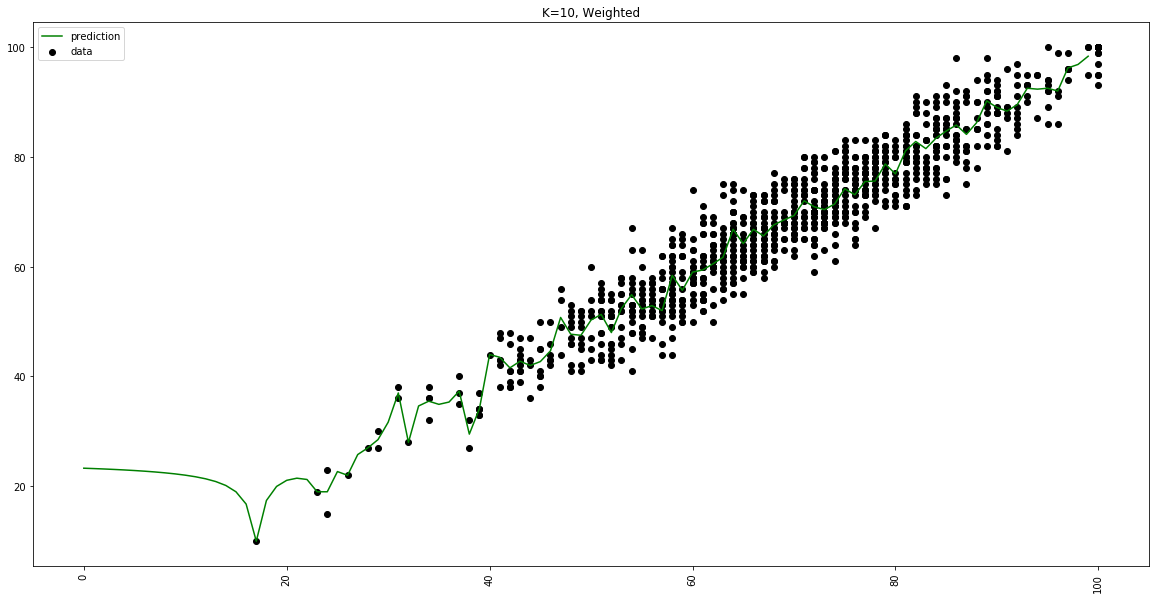

In [9]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(data.RScore)
Y = data.WScore
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 100, 1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xticks(rotation=90)
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.90 (+/- 0.02)
Weighted Accuracy: 0.90 (+/- 0.02)


KNN model is showing 90% accuracy in both weighted and unweighted methods for predicting Writing Score provided Reading Score

## OLS Regression Model

In [11]:
# Instantiate and fit model

regr = linear_model.LinearRegression()
X = pd.DataFrame(data.RScore)
Y = data.WScore
regr.fit(X, Y)

# Inspect the results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [0.99353111]

Intercept: 
 -0.667553640932951

R-squared:
0.9112574888913137


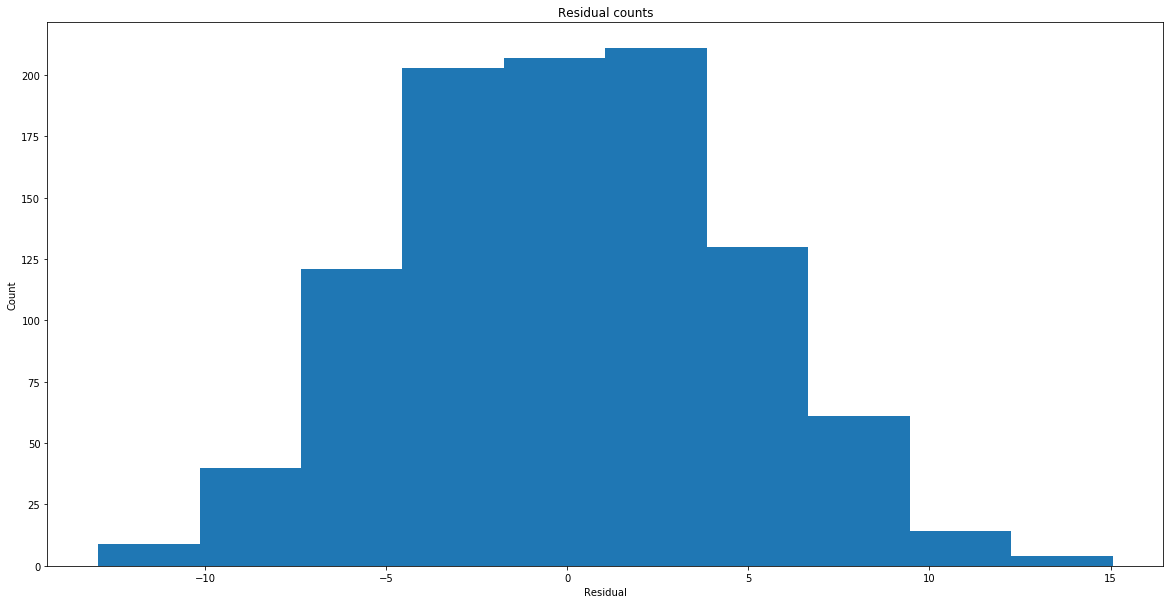

In [12]:

# Extract predicted values

predicted = regr.predict(X).ravel()
actual = data.WScore

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

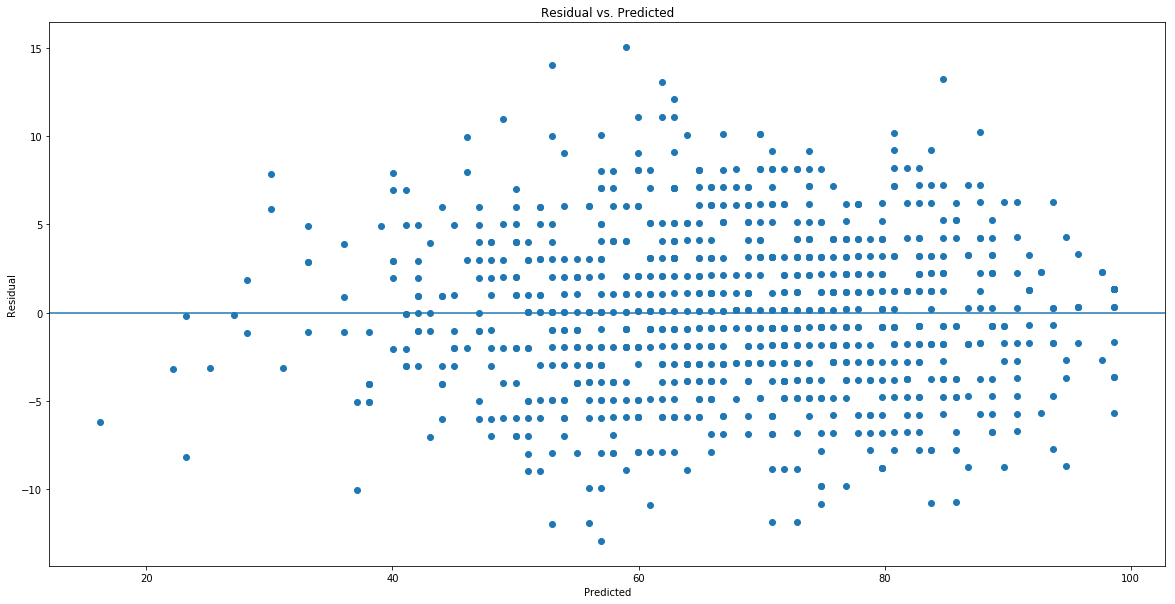

In [13]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

We see that the accuracy is tiny bit more for OLS model. The result is both normal and homoscedastic. This was easy. Let us try to use Features. And combine reading and writing scores and try predicting math scores.

## KNN Model with PCA

In [14]:
from sklearn.preprocessing import StandardScaler
data_pca = data[['RScore','WScore']].dropna()
X = StandardScaler().fit_transform(data_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)

c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 2).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.70710678]
 [ 0.70710678]]
Eigenvalue 1: 0.04544737022397616
----------------------------------------
Eigenvector 2: 
[[-0.70710678]
 [-0.70710678]]
Eigenvalue 2: 1.9565546317780258
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.02270096 0.97729904]


In [16]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X. Take only the second component
P = eig_vec_cov[:, 1]

# Transform X into Y.
Y = P.T.dot(Xt)

data['RWScore'] = Y


In [17]:
data.describe()

,MScore,RScore,WScore,RWScore
count,1000.000,1000.000,1000.000,1000.000
mean,66.089,69.169,68.054,-0.000
std,15.163,14.600,15.196,1.399
min,0.000,17.000,10.000,-2.981
25%,57.000,59.000,57.750,-0.984
50%,66.000,70.000,69.000,-0.083
75%,77.000,79.000,79.000,0.959
max,100.000,100.000,100.000,5.231


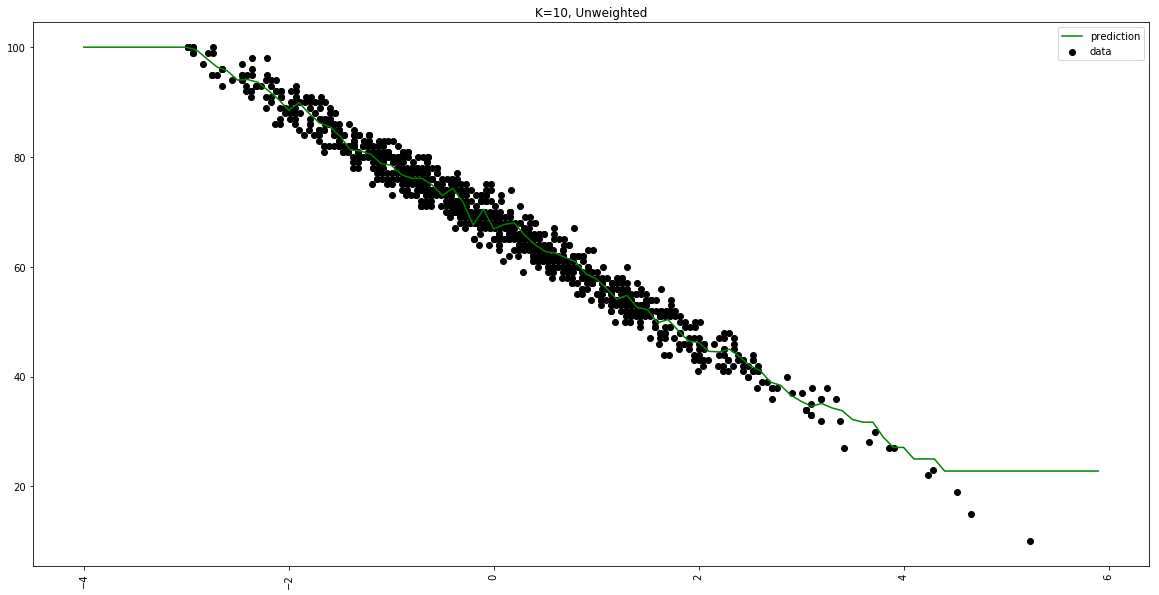

In [18]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(data.RWScore)
Y = data.WScore
knn.fit(X, Y)

# Set up prediction line
T = np.arange(-4, 6, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xticks(rotation=90)
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

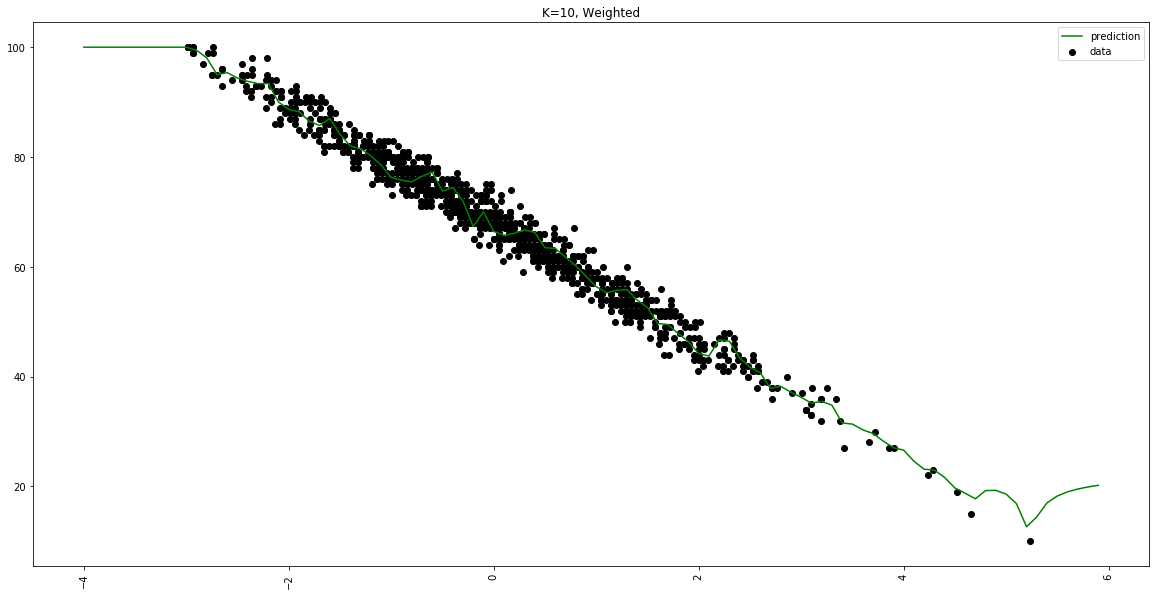

In [19]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(data.RWScore)
Y = data.WScore
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(-4, 6, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.xticks(rotation=90)
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.97 (+/- 0.01)
Weighted Accuracy: 0.99 (+/- 0.00)


Though both weighted and unweighted models seems to be overfitting, unweighted looks a bit more realistic. Let us use OLS model now and see the changes.

## OLS Model with PCA

In [21]:
# Instantiate and fit model

regr = linear_model.LinearRegression()
X = pd.DataFrame(data.RWScore)
Y = data.WScore
regr.fit(X, Y)

# Inspect the results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-10.7395783]

Intercept: 
 68.054

R-squared:
0.977299038573124


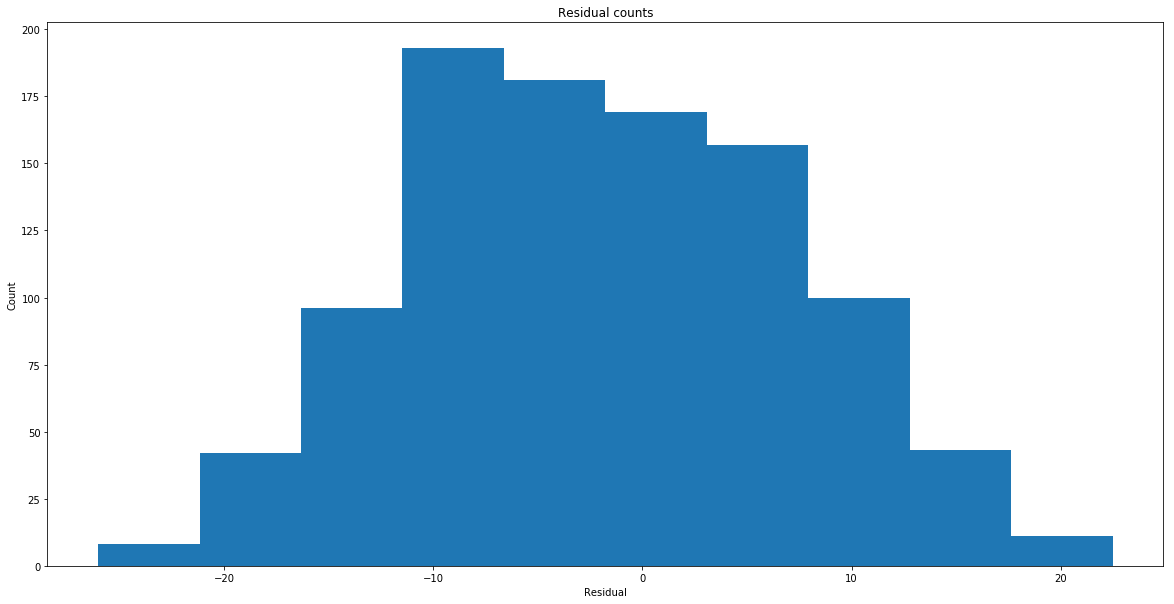

In [22]:

# Extract predicted values

predicted = regr.predict(X).ravel()
actual = data.MScore

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

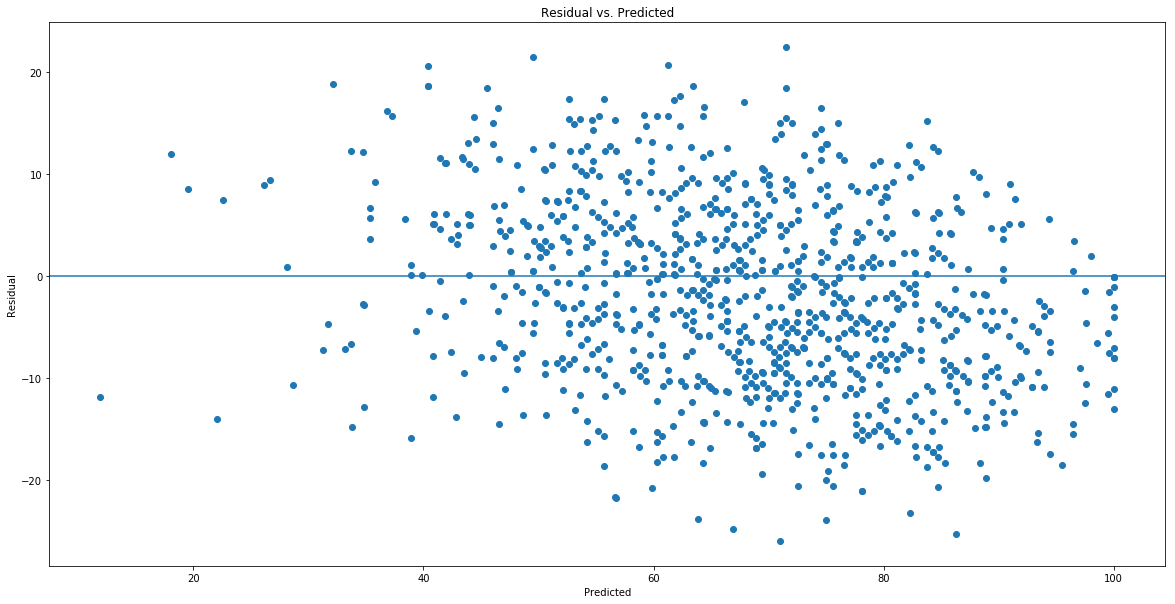

In [23]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

OLS Model seems to be normal and homoscedastic having the same accuracy as unweighted KNN. 